## plot before loading model weights
581


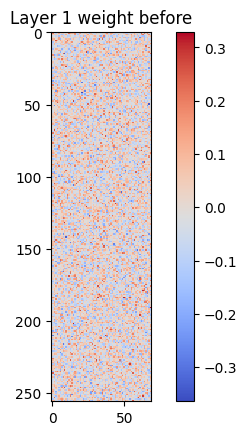

/tmp/ipykernel_24723/1898085545.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load('./models/SmallLowGearAntTRP-v0__ppo__0__1741093440.pth

Agent(
  (critic): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): BetaHead(
      (fcc_c0): Linear(in_features=256, out_features=8, bias=True)
      (fcc_c1): Linear(in_features=256, out_features=8, bias=True)
    )
  )
)
torch.Size([256, 69])


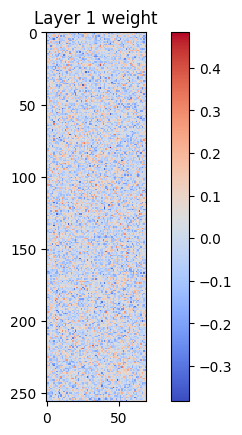

581


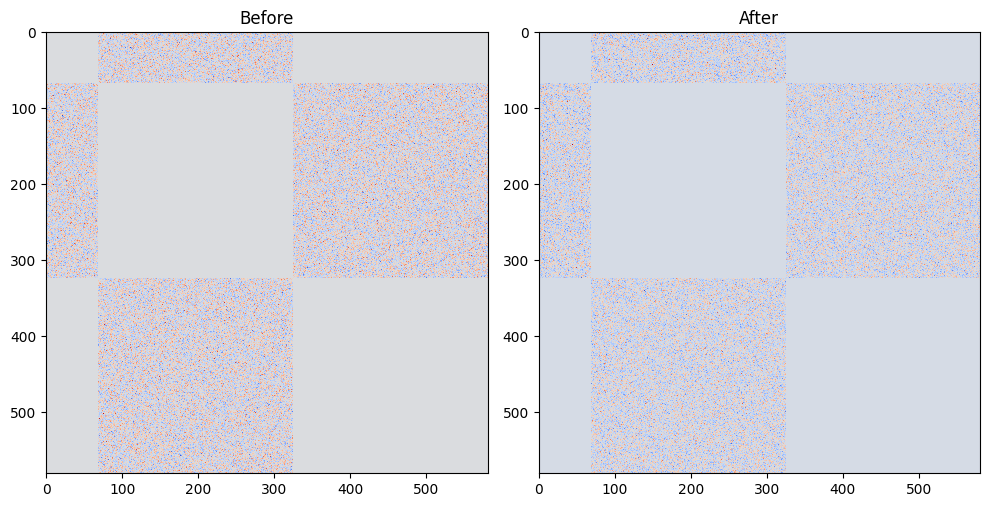

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from util import layer_init, BetaHead, make_env

import gym
import trp_env
import tiny_homeostasis
import thermal_regulation

def create_connectivity_matrix(layers: nn.Sequential):
    
	total_neurons = 0
	for layer in layers:
		if isinstance(layer, nn.Linear):
			# layer = layers[i]
			total_neurons += layer.out_features
		
	total_neurons += layers[0].in_features
	print(total_neurons)
    # total_neurons =
	C = np.zeros((total_neurons, total_neurons))

	start_idx = 0  # Index of first neuron in the current layer
	for layer in layers:
		# layer = layers[i]
		if isinstance(layer, nn.Linear):
			C[start_idx:start_idx + layer.in_features, start_idx + layer.in_features:start_idx + layer.in_features + layer.out_features] = layer.weight.T.detach().numpy()
			C.T[start_idx:start_idx + layer.in_features, start_idx + layer.in_features:start_idx + layer.in_features + layer.out_features] = layer.weight.T.detach().numpy()
			start_idx += layer.in_features
   
	return C

class Agent(nn.Module):
	def __init__(self, envs, gaussian=False):
		super().__init__()

		self.is_gaussian = gaussian

		self.critic = nn.Sequential(
			layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
			nn.Tanh(),
			layer_init(nn.Linear(256, 256)),
			nn.Tanh(),
			layer_init(nn.Linear(256, 1), std=1.0),
		)

		self.actor = nn.Sequential(
			layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
			nn.Tanh(),
			layer_init(nn.Linear(256, 256)),
			nn.Tanh(),
			BetaHead(256, np.prod(envs.single_action_space.shape)),
		)

	def get_value(self, x):
		return self.critic(x)

	def get_action_and_value(self, x, action=None):
		probs = self.actor(x)
		if action is None:
			action = probs.sample()
		return action, probs.log_prob(action), probs.entropy(), self.critic(x)

seed_ = (1 + 1) * 1
envs = gym.vector.SyncVectorEnv(
    [make_env(env_id='SmallLowGearAntTRP-v0',
                seed=seed_ + i,
                idx=i,
                capture_video=False,
                run_name='test',
                max_episode_steps=60_000,
                gaussian_policy=False) for i in range(1)]
)

agent = Agent(envs=envs, gaussian=False)

print("## plot before loading model weights")
C1 = create_connectivity_matrix(agent.actor)
layer1_before = agent.actor[0]
plt.imshow(layer1_before.weight.detach().numpy(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Layer 1 weight before')
plt.show()
#load the model
agent.load_state_dict(torch.load('./models/SmallLowGearAntTRP-v0__ppo__0__1741093440.pth'))
print(agent)

layer1 = agent.actor[0]
print(layer1.weight.shape)
# plot the weight as a matrix
plt.imshow(layer1.weight.detach().numpy(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Layer 1 weight')
plt.show()

C2 = create_connectivity_matrix(agent.actor)

#plot before and after side by side with same scale
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(C1, cmap='coolwarm', interpolation='nearest')
axs[0].set_title('Before')
axs[1].imshow(C2, cmap='coolwarm', interpolation='nearest')
axs[1].set_title('After')
plt.tight_layout()
# plt.savefig('connectivity_before_vs_after.png')
plt.show()


['connectivity_matrix_1.npy', 'connectivity_matrix_54.npy', 'connectivity_matrix_107.npy', 'connectivity_matrix_160.npy', 'connectivity_matrix_213.npy', 'connectivity_matrix_266.npy']


/tmp/ipykernel_24723/4049285869.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(str(i) + '.png'))


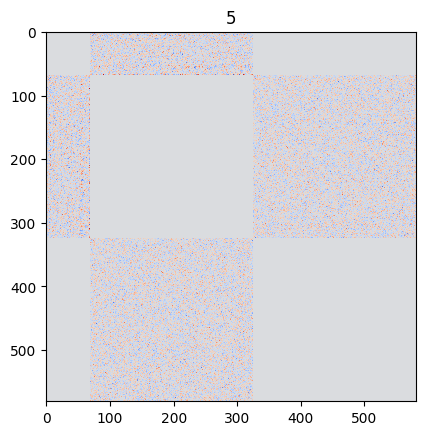

In [2]:
import numpy as np

dir = './connectivity_matrix/'
#plot all the .npy files and make a gif
import os
import imageio
import matplotlib.pyplot as plt

files = os.listdir(dir)
files = [f for f in files if f.endswith('.npy')]
#sort on the number in the filename
files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
# files = sorted(files)
print(files)

#read all the matrix into an array
cm = []
for f in files:
    C = np.load(dir + f)
    cm.append(C)

#scale all the matrix to the same scale
# max_val = max([np.max(C) for C in cm])
# min_val = min([np.min(C) for C in cm])
# print(max_val, min_val)
for i in range(len(cm)):
    #scale values to between -1 and 1
    max_val = np.max(cm[i])
    min_val = np.min(cm[i])
    cm[i] = 2 * (cm[i] - min_val) / (max_val - min_val) - 1
    
    
    


images = []
for i, C in enumerate(cm):
    plt.imshow(C, cmap='coolwarm', interpolation='nearest')
    # plt.colorbar()
    plt.title(str(i))
    plt.savefig(str(i) + '.png')
    images.append(imageio.imread(str(i) + '.png'))
    os.remove(str(i) + '.png')
imageio.mimsave('connectivity_matrices.gif', images, duration=10)




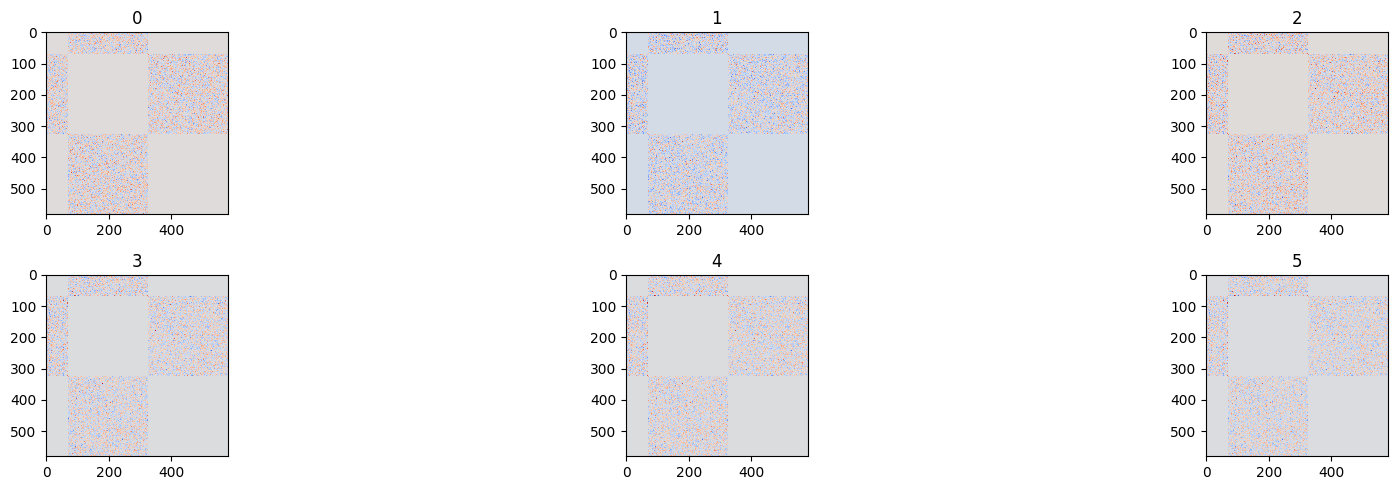

In [3]:
#plot the 6 connectivity matrices in a single plot
fig, axs = plt.subplots(2, 3, figsize=(20, 5))
for i, C in enumerate(cm):

    ax = axs[i//3, i%3]
    ax.imshow(C, cmap='coolwarm', interpolation='nearest')
    ax.set_title(i)
plt.tight_layout()
plt.savefig('connectivity_matrices.png')
plt.show()

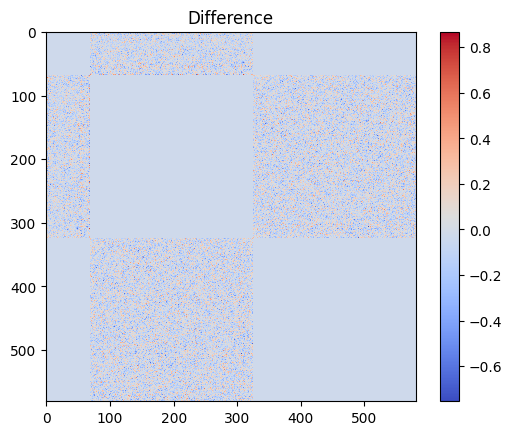

In [4]:
diff = cm[-1] - cm[0]
plt.imshow(diff, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Difference')
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import util
from util import layer_init, BetaHead, make_env

import gym
import trp_env
import tiny_homeostasis
import thermal_regulation


In [2]:
seed_ = (1 + 1) * 1
envs = gym.vector.SyncVectorEnv(
    [make_env(env_id='SmallLowGearAntTRP-v0',
                seed=seed_ + i,
                idx=i,
                capture_video=False,
                run_name='test',
                max_episode_steps=60_000,
                gaussian_policy=False) for i in range(1)]
)

In [3]:
import torch
import torch.nn as nn
import numpy as np

class Agent(nn.Module):
    def __init__(self, envs, gaussian=False):
        super().__init__()

        self.is_gaussian = gaussian

        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 1), std=1.0),
        )

        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            BetaHead(256, np.prod(envs.single_action_space.shape)),
        )

    def expand_layer(self, network, layer_idx, new_out_features):
        """ Expands a given layer and updates the next layer's input features """
        old_layer = network[layer_idx]
        next_layer = network[layer_idx + 2]  # Skip activation function (Tanh)

        if not isinstance(old_layer, nn.Linear) or not isinstance(next_layer, nn.Linear):
            raise ValueError(f"Layers at indices {layer_idx} and {layer_idx+2} must be Linear layers.")

        in_features = old_layer.in_features
        old_out_features = old_layer.out_features

        # Expand first layer
        new_layer = nn.Linear(in_features, new_out_features)
        new_layer.weight.data[:old_out_features, :] = old_layer.weight.data
        new_layer.bias.data[:old_out_features] = old_layer.bias.data
        nn.init.xavier_uniform_(new_layer.weight.data[old_out_features:, :])
        nn.init.zeros_(new_layer.bias.data[old_out_features:])

        # Expand second layer (update input features)
        old_next_weights = next_layer.weight.data.clone()
        old_next_bias = next_layer.bias.data.clone()

        new_next_layer = nn.Linear(new_out_features, next_layer.out_features)
        new_next_layer.weight.data[:, :old_out_features] = old_next_weights
        new_next_layer.bias.data = old_next_bias
        nn.init.xavier_uniform_(new_next_layer.weight.data[:, old_out_features:])
        
        # Replace layers in network
        network[layer_idx] = new_layer
        network[layer_idx + 2] = new_next_layer  # Skip activation function

    def expand_actor(self, layer_idx, new_out_features):
        self.expand_layer(self.actor, layer_idx, new_out_features)

    def expand_critic(self, layer_idx, new_out_features):
        self.expand_layer(self.critic, layer_idx, new_out_features)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):
    def __init__(self, envs, gaussian=False):
        super().__init__()
        self.is_gaussian = gaussian
        
        obs_dim = np.array(envs.single_observation_space.shape).prod()
        act_dim = np.prod(envs.single_action_space.shape)

        self.critic = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 1), std=1.0),
        )

        self.actor = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 256)),
            nn.Tanh(),
            BetaHead(256, act_dim),
        )

    def expand_layer(self, network, layer_idx, new_out_features, new_in_features):
        """ Expands any given layer in a sequential network, including BetaHead. """
        # if layer_idx >= len(network) or not isinstance(network[layer_idx], nn.Linear) or not isinstance(network[layer_idx], util.BetaHead):
        #     raise ValueError(f"Layer {layer_idx} is not a Linear layer or does not exist. It is of type {type(network[layer_idx])}.")
        
        old_layer = network[layer_idx]
        in_features = old_layer.in_features
        old_out_features = old_layer.out_features

        # Expand current layer
        if isinstance(old_layer, nn.Linear):
            if new_in_features == -1:
                new_in_features = in_features
                    
            new_layer = nn.Linear(new_in_features, new_out_features)
            new_layer.weight.data[:old_out_features, :in_features] = old_layer.weight.data
            new_layer.bias.data[:old_out_features] = old_layer.bias.data
            nn.init.xavier_uniform_(new_layer.weight.data[old_out_features:, in_features:])
            nn.init.zeros_(new_layer.bias.data[old_out_features:])
            
            
        
                
        elif isinstance(old_layer, BetaHead):
            new_layer = BetaHead(in_features, new_out_features)
            new_layer.fcc_c0.weight.data[:old_out_features, :] = old_layer.fcc_c0.weight.data
            new_layer.fcc_c0.bias.data[:old_out_features] = old_layer.fcc_c0.bias.data
            new_layer.fcc_c1.weight.data[:old_out_features, :] = old_layer.fcc_c1.weight.data
            new_layer.fcc_c1.bias.data[:old_out_features] = old_layer.fcc_c1.bias.data
            nn.init.xavier_uniform_(new_layer.fcc_c0.weight.data[old_out_features:, :])
            nn.init.zeros_(new_layer.fcc_c0.bias.data[old_out_features:])
            nn.init.xavier_uniform_(new_layer.fcc_c1.weight.data[old_out_features:, :])
            nn.init.zeros_(new_layer.fcc_c1.bias.data[old_out_features:])
        
        network[layer_idx] = new_layer

        # Update next layer if it's a Linear layer or BetaHead
        next_layer_idx = layer_idx + 2  # Skip activation
        if next_layer_idx < len(network):
            next_layer = network[next_layer_idx]
            if isinstance(next_layer, nn.Linear):
                old_next_weights = next_layer.weight.data.clone()
                old_next_bias = next_layer.bias.data.clone()
                
                new_next_layer = nn.Linear(new_out_features, next_layer.out_features)
                new_next_layer.weight.data[:, :old_out_features] = old_next_weights
                new_next_layer.bias.data = old_next_bias
                nn.init.xavier_uniform_(new_next_layer.weight.data[:, old_out_features:])
                
                network[next_layer_idx] = new_next_layer
            elif isinstance(next_layer, BetaHead):
                next_layer.expand(new_in_features=new_out_features, new_out_features=next_layer.out_features)

    def expand_actor(self, layer_idx, new_out_features, new_in_features):
        self.expand_layer(self.actor, layer_idx, new_out_features, new_in_features)

    def expand_critic(self, layer_idx, new_out_features, new_in_features):
        self.expand_layer(self.critic, layer_idx, new_out_features, new_in_features)


In [6]:
agent = Agent(envs=envs, gaussian=False)
agent.load_state_dict(torch.load('./models/SmallLowGearAntTRP-v0__ppo__0__1741093440.pth'))
print(agent)

/tmp/ipykernel_2611118/2930552179.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load('./models/SmallLowGearAntTRP-v0__ppo__0__1741093440.pt

Agent(
  (critic): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): BetaHead(
      (fcc_c0): Linear(in_features=256, out_features=8, bias=True)
      (fcc_c1): Linear(in_features=256, out_features=8, bias=True)
    )
  )
)


In [7]:
agent.expand_actor(0, 300)
agent.expand_actor(2, 300)
agent.expand_actor(4, 9)
agent.actor.insert(4, nn.Linear(300, 300))
nn.init.xavier_uniform_(agent.actor[4].weight)
nn.init.zeros_(agent.actor[4].bias)
print(agent)

Agent(
  (critic): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=69, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): Tanh()
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): BetaHead(
      (fcc_c0): Linear(in_features=300, out_features=9, bias=True)
      (fcc_c1): Linear(in_features=300, out_features=9, bias=True)
    )
  )
)


In [9]:
import gym
import neurogym as ngym
from neurogym.wrappers import pass_reward
import warnings
warnings.filterwarnings('ignore')
# Task name
name = 'PerceptualDecisionMaking-v0'
# task specification (here we only specify the duration of the different trial periods)
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 500),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing}
# build task
env = gym.make(name, **kwargs)
# print task properties
print(env)
# wrapp task with pass-reward wrapper
# plot example trials with random agent
# data = ngym.utils.plot_env(env, fig_kwargs={'figsize': (12, 12)}, num_steps=100, ob_traces=['Fixation cue', 'Stim 1', 'Stim 2', 'Previous reward'])

<OrderEnforcing<PerceptualDecisionMaking>>


In [10]:
hrl_env = gym.make("SmallLowGearAntTRP-v0")
perceptual_env = pass_reward.PassReward(env)

hrl_env.seed(100)  # Seeding
perceptual_env.seed(100)

done = False

obs = hrl_env.reset()
percp_obs = perceptual_env.reset()

In [ ]:
while not done:
    # Convert observations to tensors
    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    percp_obs_tensor = torch.tensor(percp_obs, dtype=torch.float32)
    
    #concatenate the observations
    obs_tensor = torch.cat((obs_tensor, percp_obs_tensor), dim=0)
    
    # Get action from the actor
    action, _, _, _ = agent.actor(obs_tensor)
    action = action.detach().numpy()

    # Take action in the environment
    perceptual_action = action[-1]
    obs, reward, done, info = hrl_env.step(action[:-1])
    percp_obs, percp_reward, percp_done, percp_info = perceptual_env.step(perceptual_env)